In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import tinyarray
from types import SimpleNamespace

In [4]:
# n_ = 1
# lat = kwant.lattice.honeycomb(a=1.0, norbs=n_)
# a, b = lat.sublattices
# nnn_hoppings_a = (((-1, 0), a, a), ((0,  1), a, a), ((1, -1), a, a))
# nnn_hoppings_b = ((( 1, 0), b, b), ((0, -1), b, b), ((-1, 1), b, b))
# nnn_hoppings_all = nnn_hoppings_a + nnn_hoppings_b
# lat_neighbors_2 = [kwant.builder.HoppingKind(*hop) for hop in nnn_hoppings_all]

# if n_ == 1:
#     t2 = -1e-9  #*tinyarray.array([[1, 0], [0, 1]])
#     tso = -0.05j #*tinyarray.array([[1, 0], [0, -1]])
#     t = -1.0    #*tinyarray.array([[1, 0], [0, 1]])
# elif n_ == 2:
#     t2 = -1e-9 * tinyarray.array([[1, 0], [0, 1]])
#     tso = -0.05j * tinyarray.array([[1, 0], [0, -1]])
#     t = -1.0 * tinyarray.array([[1, 0], [0, 1]])
# else:
#     raise ValueError("n_ must be 1 or 2")


# ribbon = kwant.Builder()
# for i in range(10):
#     for j in range(10):
#         if j > 0: ribbon[a(i, j)] = 0*t
#         if j < 9: ribbon[b(i, j)] = 0*t
# ribbon[lat.neighbors(1)] = t
# ribbon[lat_neighbors_2] = t2 + tso

# rib_lead = kwant.Builder(kwant.TranslationalSymmetry([-1, 0]))
# for j in range(10):
#     if j > 0: rib_lead[a(0, j)]=0*t
#     if j < 9: rib_lead[b(0, j)]=0*t
# rib_lead[lat.neighbors(1)]= t
# rib_lead[lat_neighbors_2]=t2 + tso

# ribbon.attach_lead(rib_lead)
# ribbon.attach_lead(rib_lead.reversed())

# # attach lateral leads
# lead_lat = kwant.Builder(kwant.TranslationalSymmetry(lat.vec([0, 1])))
# for i in range(4):
#     lead_lat[a(i+3, 0)] = 0*t
#     lead_lat[b(i+3, 0)] = 0*t
# lead_lat[lat.neighbors(1)] = t
# lead_lat[lat_neighbors_2] = t2 + tso
# ribbon.attach_lead(lead_lat)
# ribbon.attach_lead(lead_lat.reversed())

# kwant.plot(ribbon, show=False)
# plt.show()

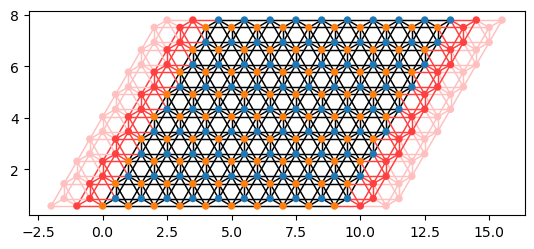

In [132]:
n_ = 1
lat = kwant.lattice.honeycomb(a=1.0, norbs=n_)
a, b = lat.sublattices
nnn_hoppings_a = (((-1, 0), a, a), ((0,  1), a, a), ((1, -1), a, a))
nnn_hoppings_b = ((( 1, 0), b, b), ((0, -1), b, b), ((-1, 1), b, b))
nnn_hoppings_all = nnn_hoppings_a + nnn_hoppings_b
lat_neighbors_2 = [kwant.builder.HoppingKind(*hop) for hop in nnn_hoppings_all]

def onsite(site, params):
    stagger = params.Us if site.family == a else -params.Us
    impurity = 0.0*kwant.digest.gauss(repr(site))
    return stagger + impurity
def hopping(site1, site2, params):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    return -1*np.exp(-1j*params.phi/2*(x2 - x1)*(y1 + y2))
def nnn_hopping(site1, site2, params):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    return (params.t2 + 1j*params.t_so)*np.exp(-1j*params.phi/2*(x2 - x1)*(y1 + y2))
if n_ == 1:
    t2 = -1e-9  #*tinyarray.array([[1, 0], [0, 1]])
    tso = -0.1j #*tinyarray.array([[1, 0], [0, -1]])
    t = -1.0    #*tinyarray.array([[1, 0], [0, 1]])
elif n_ == 2:
    t2 = -1e-9 * tinyarray.array([[1, 0], [0, 1]])
    tso = -0.1j * tinyarray.array([[1, 0], [0, -1]])
    t = -1.0 * tinyarray.array([[1, 0], [0, 1]])
else:
    raise ValueError("n_ must be 1 or 2")


ribbon = kwant.Builder()
for i in range(10):
    for j in range(10):
        if j > 0: ribbon[a(i, j)] = onsite
        if j < 9: ribbon[b(i, j)] = onsite
ribbon[lat.neighbors(1)] = hopping
ribbon[lat_neighbors_2] = nnn_hopping

rib_lead = kwant.Builder(kwant.TranslationalSymmetry([-1, 0]))
for j in range(10):
    if j > 0: rib_lead[a(0, j)]= 0
    if j < 9: rib_lead[b(0, j)]= 0
rib_lead[lat.neighbors(1)]= hopping
rib_lead[lat_neighbors_2]= nnn_hopping

ribbon.attach_lead(rib_lead)
ribbon.attach_lead(rib_lead.reversed())

# attach lateral leads
lead_lat = kwant.Builder(kwant.TranslationalSymmetry(lat.vec([0, 1])))
for i in range(4):
    lead_lat[a(i+3, 0)] = 0
    lead_lat[b(i+3, 0)] = 0
lead_lat[lat.neighbors(1)] = hopping
lead_lat[lat_neighbors_2] = nnn_hopping
# ribbon.attach_lead(lead_lat)
# ribbon.attach_lead(lead_lat.reversed())

kwant.plot(ribbon, show=False)
plt.show()

In [135]:
parameters = SimpleNamespace()
parameters.t = 1
parameters.t2 = 0.0
parameters.t_so = 0.0
parameters.phi = 0.0
parameters.Us = 0.0

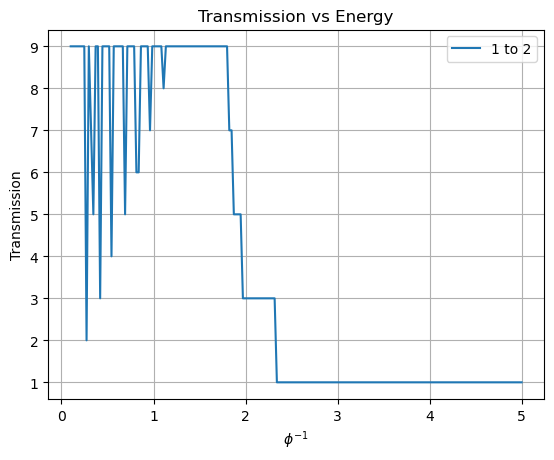

In [148]:
transmission1 = []
transmission2 = []
energy = 0.01
rec_phis= np.linspace(0.1, 5, 200)
for p in 1/rec_phis:
    parameters.phi = p
    smatrix = kwant.smatrix(ribbon.finalized(), energy=energy, params=dict(params=parameters))
    transmission1.append(smatrix.transmission(0, 1))
    # transmission2.append(smatrix.transmission(1, 2))
plt.plot(rec_phis, transmission1, label='1 to 2')
# plt.plot(rec_phis, transmission2, label='2 to 3')
plt.xlabel(r'$\phi^{-1}$')
plt.ylabel('Transmission')
plt.title('Transmission vs Energy')
plt.legend()
plt.grid()
plt.show()